In [1]:
import matplotlib.pyplot as plt
import utils
import tensorflow.keras as keras
import numpy as np

from tensorflow.keras.layers import *

%matplotlib inline

In [2]:
images = utils.get_data()

In [3]:
images.shape

(70000, 784)

In [4]:
images = images.reshape(-1,28,28,1)

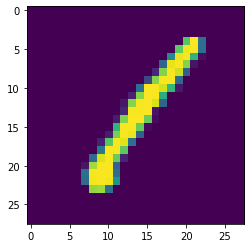

In [5]:
plt.imshow(images[0].reshape(28,28))

### Creating Base Network For Visual Loss

In [6]:
(X,Y),(x,y) = keras.datasets.mnist.load_data()

X = X.reshape(-1,28,28,1) / 255.
x = x.reshape(-1,28,28,1) / 255.

Y = keras.utils.to_categorical(Y)
y = keras.utils.to_categorical(y)

In [7]:
X.shape,x.shape,Y.shape,y.shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000, 10), (10000, 10))

In [100]:
loss_input = Input(shape=(28,28,1))

loss_conv = Conv2D(32,3,activation="relu")(loss_input)
loss_conv = Conv2D(64,3,activation="relu")(loss_conv)
loss_pool = MaxPool2D()(loss_conv)
loss_conv = Conv2D(128,2,activation="relu")(loss_pool)
loss_enc = BatchNormalization()(loss_conv)
loss_flatten = Flatten()(loss_enc)
loss_dense = Dense(512,activation="relu")(loss_flatten)
loss_out = Dense(10,activation="softmax")(loss_dense)

loss_train = keras.Model(loss_input,loss_out)
loss_enc = keras.Model(loss_input,loss_enc)

In [101]:
loss_train.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])

In [102]:
loss_train.fit(X,Y,batch_size=256,epochs=5,validation_data=(x,y))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 12s 197us/sample - loss: 0.1300 - accuracy: 0.9649 - val_loss: 0.9680 - val_accuracy: 0.9821
Epoch 2/5
60000/60000 [==============================] - 16s 262us/sample - loss: 0.0295 - accuracy: 0.9906 - val_loss: 0.0789 - val_accuracy: 0.9905
Epoch 3/5
60000/60000 [==============================] - 16s 272us/sample - loss: 0.0174 - accuracy: 0.9943 - val_loss: 0.0304 - val_accuracy: 0.9897
Epoch 4/5
60000/60000 [==============================] - 16s 275us/sample - loss: 0.0117 - accuracy: 0.9965 - val_loss: 0.0404 - val_accuracy: 0.9875
Epoch 5/5
60000/60000 [==============================] - 17s 289us/sample - loss: 0.0086 - accuracy: 0.9973 - val_loss: 0.0537 - val_accuracy: 0.9859


In [103]:
loss_train.save_weights("weights/models/conv_autoencoder_with_perceptual_loss/loss_model")

### Defining loss

In [104]:
def visual_loss(y_true,y_pred):
    y_true = loss_enc(y_true)
    y_pred = loss_enc(y_pred)
    return keras.losses.mse(y_true,y_pred)

In [105]:
inputs = Input(shape=(28,28,1))

enc = Conv2D(32,3,activation="relu",padding="same")(inputs)
enc = MaxPool2D()(enc)
enc = Conv2D(48,3,activation="linear",padding="same")(enc)
enc = MaxPool2D()(enc)
enc = BatchNormalization()(enc)

dense = Flatten()(enc)
dense = Dense(512,activation="relu")(dense)
encodings = Dense(128,activation="linear")(dense)
dense = Dense(512,activation="relu")(encodings)
dense = Dense(2352)(dense)
dense = Reshape((7,7,48))(dense)

dec = UpSampling2D()(dense)
dec = Conv2D(48,3,activation="linear",padding="same")(dec)
dec = UpSampling2D()(dec)
dec = BatchNormalization()(dec)
dec = Conv2D(32,3,activation="relu",padding="same")(dec)
dec = BatchNormalization()(dec)
dec = Conv2D(1,4,activation="sigmoid",padding="same")(dec)

model = keras.Model(inputs,dec)
encoder = keras.Model(inputs,encodings)

In [106]:
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 48)        13872     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 48)          0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 7, 7, 48)          192       
_________________________________________________________________
flatten_6 (Flatten)          (None, 2352)              0  

In [107]:
encoder.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 48)        13872     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 48)          0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 7, 7, 48)          192       
_________________________________________________________________
flatten_6 (Flatten)          (None, 2352)              0  

In [108]:
# model.load_weights("weights/models/conv_autoencoder_with_perceptual_loss/autoencoder")

In [109]:
model.compile(optimizer="adam",loss=visual_loss)

In [133]:
model.fit(images,images,batch_size=1024,epochs=2)

Train on 70000 samples
Epoch 1/2
70000/70000 [==============================] - 37s 525us/sample - loss: 0.0058
Epoch 2/2
70000/70000 [==============================] - 37s 531us/sample - loss: 0.0052


In [163]:
model.save_weights("weights/models/conv_autoencoder_with_perceptual_loss/autoencoder")
encoder.save_weights("weights/models/conv_autoencoder_with_perceptual_loss/encoder")

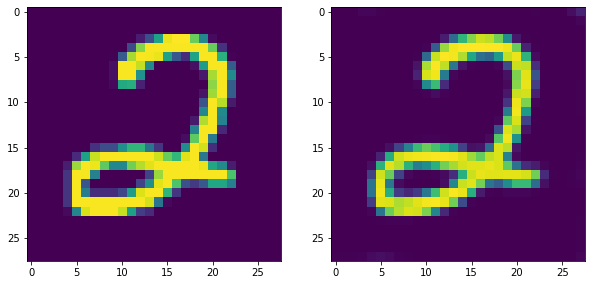

In [164]:
img = images[np.random.randint(images.shape[0])].reshape(28,28)#
pred = model.predict(img.reshape(1,28,28,1)).reshape(28,28)

fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(img)
axes[1].imshow(pred)